In [1]:
import copy
import json
import math
import os
import urllib.request
from urllib.error import HTTPError

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

from IPython.display import set_matplotlib_formats
from matplotlib import cm
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from tqdm.notebook import tqdm

sns.set()

In [2]:
def check_dir(PATH, type_check='dir'):
    assert PATH not in ['dir', 'file'], 'type_check must be "dir" or "file"'
    
    if type_check=='dir':
        if not os.path.isdir(PATH):
            os.makedirs(PATH, exist_ok=True)
    
    elif type_check=='file':
        return os.path.isfile(PATH)

DATASET_PATH = './data'
CHECKPOINT_PATH = './saved_models/InitOptim'
check_dir(DATASET_PATH, 'dir')
check_dir(CHECKPOINT_PATH, 'dir')

In [3]:
# random_seed = 42

# def set_seed(seed):
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     random.seed(seed)
    
#     if torch.cuda.is_available():
#         torch.cuda.manual_seed(seed)
#         torch.cuda.manual_seed_all(seed) # if use multi-GPU

pl.seed_everything(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# set_seed(random_seed)

device = torch.device('cpu') if not torch.cuda.is_available() else torch.device('cuda:0')
print(device)
print(torch.cuda.get_device_name(0))

Global seed set to 42


cuda:0
NVIDIA GeForce RTX 3080 Ti


In [4]:
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial4/"

# Files to download
pretrained_files = [
    "FashionMNIST_SGD.config",
    "FashionMNIST_SGD_results.json",
    "FashionMNIST_SGD.tar",
    "FashionMNIST_SGDMom.config",
    "FashionMNIST_SGDMom_results.json",
    "FashionMNIST_SGDMom.tar",
    "FashionMNIST_Adam.config",
    "FashionMNIST_Adam_results.json",
    "FashionMNIST_Adam.tar",
]

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print(
                "Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n",
                e,
            )

In [5]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.2861,), (0.3530,))])

train_dataset = FashionMNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

0it [00:00, ?it/s]

Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz


0it [00:00, ?it/s]

Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz


0it [00:00, ?it/s]

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz
Processing...


C:\Users\spruce\anaconda3\envs\light\lib\site-packages\torchvision\datasets\mnist.py:335: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed).view(length, num_rows, num_cols)


Done!


In [6]:
train_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False, pin_memory=True)
val_loader = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False, pin_memory=True)
test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False, pin_memory=True)

In [7]:
print('Mean', (train_dataset.data.float() / 255.0).mean().item())
print('Std', (train_dataset.data.float() / 255.0).std().item())

Mean 0.28604060411453247
Std 0.3530242443084717


In [8]:
imgs, _ = next(iter(train_loader))

print(f'Mean : {imgs.mean().item():5.4f}')
print(f'Standard deviation : {imgs.std().item():5.3f}')
print(f'Maximum : {imgs.max().item():5.3f}')
print(f'Minimum : {imgs.min().item():5.3f}')

Mean : 0.0203
Standard deviation : 1.011
Maximum : 2.022
Minimum : -0.810


In [9]:
class BaseNetwork(nn.Module):
    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
        super().__init__()
        
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index - 1], layer_sizes[layer_index]), act_fn]
        
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        
        self.layers = nn.ModuleList(layers)
        
        self.config = {
            'act_fn' : act_fn.__class__.__name__,
            'input_size' : input_size,
            'num_classes' : num_classes,
            'hidden_sizes' : hidden_sizes,}
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for layer in self.layers:
            x = layer(x)
        return x

In [10]:
class Identity(nn.Module):
    def forward(self, x):
        return x
    
act_fn_by_name = {'tanh' : nn.Tanh, 'relu' : nn.ReLU, 'identity' : Identity}

In [11]:
##############################################################


def plot_dists(val_dict, color="C0", xlabel=None, stat="count", use_kde=True):
    columns = len(val_dict)
    fig, ax = plt.subplots(1, columns, figsize=(columns * 3, 2.5))
    fig_index = 0
    for key in sorted(val_dict.keys()):
        key_ax = ax[fig_index % columns]
        sns.histplot(
            val_dict[key],
            ax=key_ax,
            color=color,
            bins=50,
            stat=stat,
            kde=use_kde and ((val_dict[key].max() - val_dict[key].min()) > 1e-8),
        )  # Only plot kde if there is variance
        hidden_dim_str = (
            r"(%i $\to$ %i)" % (val_dict[key].shape[1], val_dict[key].shape[0]) if len(val_dict[key].shape) > 1 else ""
        )
        key_ax.set_title(f"{key} {hidden_dim_str}")
        if xlabel is not None:
            key_ax.set_xlabel(xlabel)
        fig_index += 1
    fig.subplots_adjust(wspace=0.4)
    return fig


##############################################################


def visualize_weight_distribution(model, color="C0"):
    weights = {}
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            continue
        key_name = f"Layer {name.split('.')[1]}"
        weights[key_name] = param.detach().view(-1).cpu().numpy()

    # Plotting
    fig = plot_dists(weights, color=color, xlabel="Weight vals")
    fig.suptitle("Weight distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()


##############################################################


def visualize_gradients(model, color="C0", print_variance=False):
    """
    Args:
        net: Object of class BaseNetwork
        color: Color in which we want to visualize the histogram (for easier separation of activation functions)
    """
    model.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)

    # Pass one batch through the network, and calculate the gradients for the weights
    model.zero_grad()
    preds = model(imgs)
    loss = F.cross_entropy(preds, labels)  # Same as nn.CrossEntropyLoss, but as a function instead of module
    loss.backward()
    # We limit our visualization to the weight parameters and exclude the bias to reduce the number of plots
    grads = {
        name: params.grad.view(-1).cpu().clone().numpy()
        for name, params in model.named_parameters()
        if "weight" in name
    }
    model.zero_grad()

    # Plotting
    fig = plot_dists(grads, color=color, xlabel="Grad magnitude")
    fig.suptitle("Gradient distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

    if print_variance:
        for key in sorted(grads.keys()):
            print(f"{key} - Variance: {np.var(grads[key])}")


##############################################################


def visualize_activations(model, color="C0", print_variance=False):
    model.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)

    # Pass one batch through the network, and calculate the gradients for the weights
    feats = imgs.view(imgs.shape[0], -1)
    activations = {}
    with torch.no_grad():
        for layer_index, layer in enumerate(model.layers):
            feats = layer(feats)
            if isinstance(layer, nn.Linear):
                activations[f"Layer {layer_index}"] = feats.view(-1).detach().cpu().numpy()

    # Plotting
    fig = plot_dists(activations, color=color, stat="density", xlabel="Activation vals")
    fig.suptitle("Activation distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

    if print_variance:
        for key in sorted(activations.keys()):
            print(f"{key} - Variance: {np.var(activations[key])}")


##############################################################

In [12]:
model = BaseNetwork(act_fn=Identity()).to(device)

In [13]:
def const_init(model, fill=0.0):
    for name, param in model.named_parameters():
        param.data.fill_(fill)

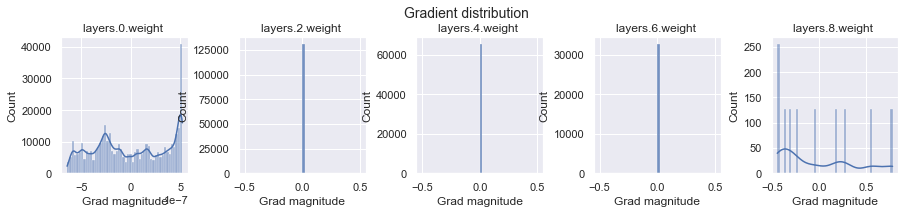

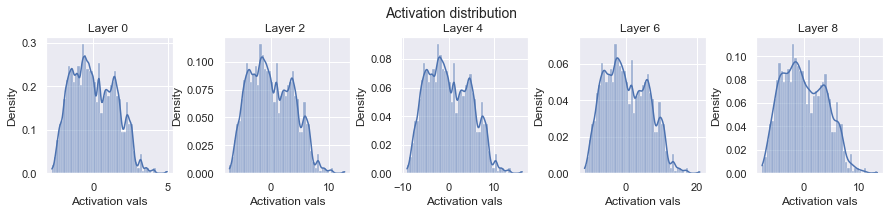

Layer 0 - Variance: 2.0591909885406494
Layer 2 - Variance: 13.500558853149414
Layer 4 - Variance: 22.128822326660156
Layer 6 - Variance: 36.27030944824219
Layer 8 - Variance: 14.862591743469238


In [14]:
const_init(model, fill=0.005)
visualize_gradients(model)
visualize_activations(model, print_variance=True)

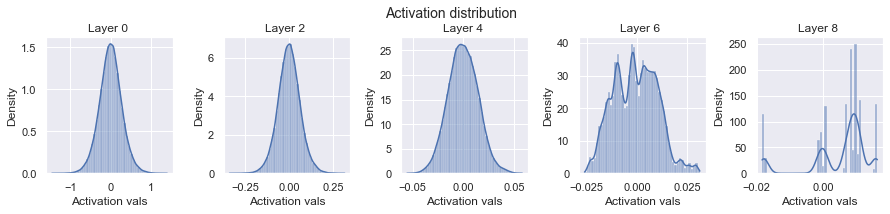

Layer 0 - Variance: 0.076258085668087
Layer 2 - Variance: 0.003971269819885492
Layer 4 - Variance: 0.00021686553373001516
Layer 6 - Variance: 0.00011627153435256332
Layer 8 - Variance: 8.120776328723878e-05


In [15]:
def var_init(model, std=0.01):
    for name, param in model.named_parameters():
        param.data.normal_(mean=0.0, std=std)
    
var_init(model, std=0.01)
visualize_activations(model, print_variance=True)

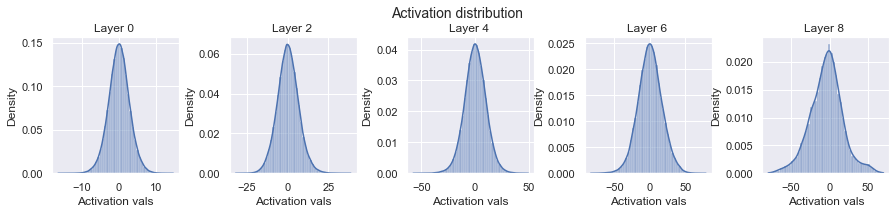

Layer 0 - Variance: 8.062074661254883
Layer 2 - Variance: 42.76082992553711
Layer 4 - Variance: 100.76249694824219
Layer 6 - Variance: 283.52923583984375
Layer 8 - Variance: 447.56396484375


In [16]:
var_init(model, std=0.1)
visualize_activations(model, print_variance=True)

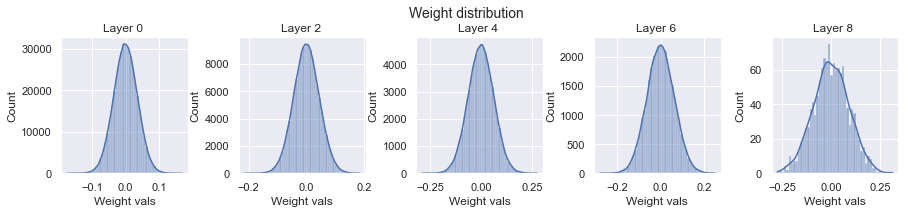

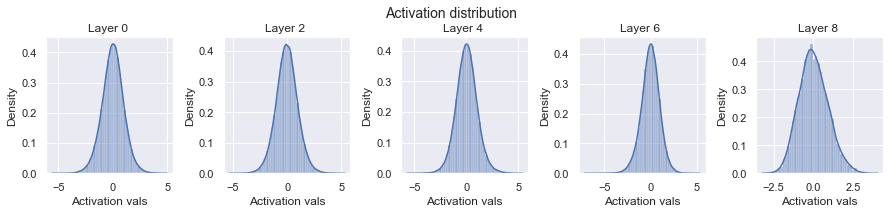

Layer 0 - Variance: 0.9926396012306213
Layer 2 - Variance: 0.9965483546257019
Layer 4 - Variance: 1.0168548822402954
Layer 6 - Variance: 0.9815053939819336
Layer 8 - Variance: 0.8224281072616577


In [17]:
def equal_var_init(model):
    for name, param in model.named_parameters():
        if name.endswith('.bias'):
            param.data.fill_(0)
        else:
            param.data.normal_(std=1.0 / math.sqrt(param.shape[1]))

equal_var_init(model)
visualize_weight_distribution(model)
visualize_activations(model, print_variance=True)

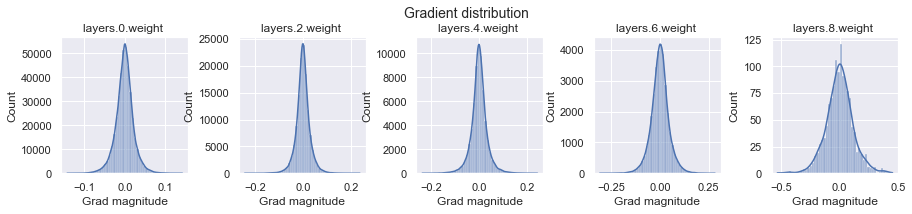

layers.0.weight - Variance: 0.0004868367104791105
layers.2.weight - Variance: 0.0008439029334113002
layers.4.weight - Variance: 0.0011132039362564683
layers.6.weight - Variance: 0.0020718947052955627
layers.8.weight - Variance: 0.013487172313034534


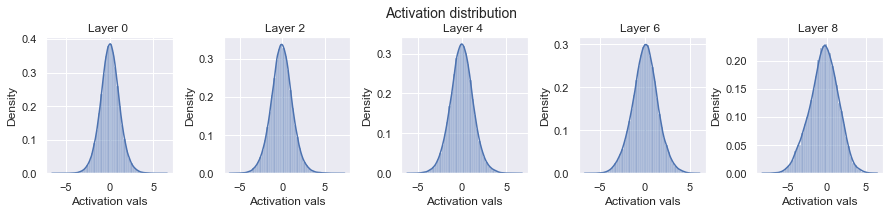

Layer 0 - Variance: 1.2180449962615967
Layer 2 - Variance: 1.5948045253753662
Layer 4 - Variance: 1.6831802129745483
Layer 6 - Variance: 1.9964511394500732
Layer 8 - Variance: 3.2772247791290283


In [18]:
def xavier_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            bound = math.sqrt(6) / math.sqrt(param.shape[0] + param.shape[1])
            param.data.uniform_(-bound, bound)


xavier_init(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)

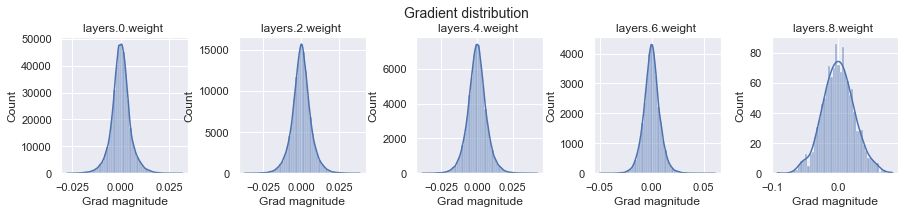

layers.0.weight - Variance: 2.3639571736566722e-05
layers.2.weight - Variance: 3.922596079064533e-05
layers.4.weight - Variance: 4.451688437256962e-05
layers.6.weight - Variance: 6.209129060152918e-05
layers.8.weight - Variance: 0.0005731083219870925


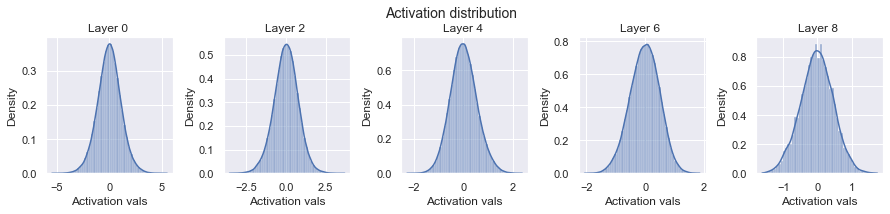

Layer 0 - Variance: 1.2432584762573242
Layer 2 - Variance: 0.5716103315353394
Layer 4 - Variance: 0.28907835483551025
Layer 6 - Variance: 0.24745070934295654
Layer 8 - Variance: 0.22790725529193878


In [19]:
model = BaseNetwork(act_fn=nn.Tanh()).to(device)
xavier_init(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)

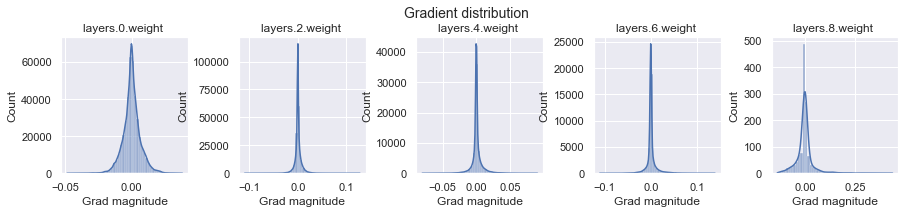

layers.0.weight - Variance: 4.43473290943075e-05
layers.2.weight - Variance: 5.2209306886652485e-05
layers.4.weight - Variance: 6.814260268583894e-05
layers.6.weight - Variance: 0.0001415087899658829
layers.8.weight - Variance: 0.0022328589111566544


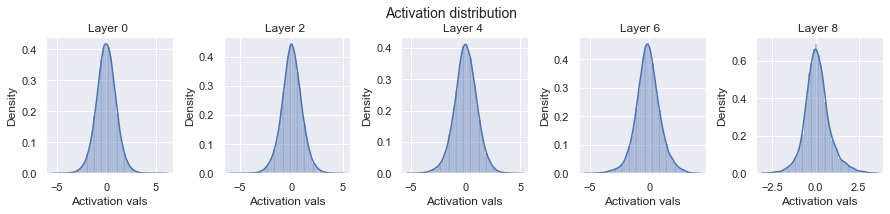

Layer 0 - Variance: 1.010335087776184
Layer 2 - Variance: 0.983228325843811
Layer 4 - Variance: 1.0887503623962402
Layer 6 - Variance: 1.0397822856903076
Layer 8 - Variance: 0.548424243927002


In [20]:
def kaiming_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        elif name.startswith("layers.0"):  # The first layer does not have ReLU applied on its input
            param.data.normal_(0, 1 / math.sqrt(param.shape[1]))
        else:
            param.data.normal_(0, math.sqrt(2) / math.sqrt(param.shape[1]))


model = BaseNetwork(act_fn=nn.ReLU()).to(device)
kaiming_init(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)

In [21]:
def _get_config_file(model_path, model_name):
    return os.path.join(model_path, model_name + ".config")


def _get_model_file(model_path, model_name):
    return os.path.join(model_path, model_name + ".tar")


def _get_result_file(model_path, model_name):
    return os.path.join(model_path, model_name + "_results.json")


def load_model(model_path, model_name, net=None):
    config_file = _get_config_file(model_path, model_name)
    model_file = _get_model_file(model_path, model_name)
    assert os.path.isfile(
        config_file
    ), f'Could not find the config file "{config_file}". Are you sure this is the correct path and you have your model config stored here?'
    assert os.path.isfile(
        model_file
    ), f'Could not find the model file "{model_file}". Are you sure this is the correct path and you have your model stored here?'
    with open(config_file) as f:
        config_dict = json.load(f)
    if net is None:
        act_fn_name = config_dict["act_fn"].pop("name").lower()
        assert (
            act_fn_name in act_fn_by_name
        ), f'Unknown activation function "{act_fn_name}". Please add it to the "act_fn_by_name" dict.'
        act_fn = act_fn_by_name[act_fn_name]()
        net = BaseNetwork(act_fn=act_fn, **config_dict)
    net.load_state_dict(torch.load(model_file))
    return net


def save_model(model, model_path, model_name):
    config_dict = model.config
    os.makedirs(model_path, exist_ok=True)
    config_file = _get_config_file(model_path, model_name)
    model_file = _get_model_file(model_path, model_name)
    with open(config_file, "w") as f:
        json.dump(config_dict, f)
    torch.save(model.state_dict(), model_file)


def train_model(net, model_name, optim_func, max_epochs=50, batch_size=256, overwrite=False):
    """Train a model on the training set of FashionMNIST.

    Args:
        net: Object of BaseNetwork
        model_name: (str) Name of the model, used for creating the checkpoint names
        max_epochs: Number of epochs we want to (maximally) train for
        patience: If the performance on the validation set has not improved for #patience epochs, we stop training early
        batch_size: Size of batches used in training
        overwrite: Determines how to handle the case when there already exists a checkpoint. If True, it will be overwritten. Otherwise, we skip training.
    """
    file_exists = os.path.isfile(_get_model_file(CHECKPOINT_PATH, model_name))
    if file_exists and not overwrite:
        print(f'Model file of "{model_name}" already exists. Skipping training...')
        with open(_get_result_file(CHECKPOINT_PATH, model_name)) as f:
            results = json.load(f)
    else:
        if file_exists:
            print("Model file exists, but will be overwritten...")

        # Defining optimizer, loss and data loader
        optimizer = optim_func(net.parameters())
        loss_module = nn.CrossEntropyLoss()
        train_loader_local = data.DataLoader(
            train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True
        )

        results = None
        val_scores = []
        train_losses, train_scores = [], []
        best_val_epoch = -1
        for epoch in range(max_epochs):
            train_acc, val_acc, epoch_losses = epoch_iteration(
                net, loss_module, optimizer, train_loader_local, val_loader, epoch
            )
            train_scores.append(train_acc)
            val_scores.append(val_acc)
            train_losses += epoch_losses

            if len(val_scores) == 1 or val_acc > val_scores[best_val_epoch]:
                print("\t   (New best performance, saving model...)")
                save_model(net, CHECKPOINT_PATH, model_name)
                best_val_epoch = epoch

    if results is None:
        load_model(CHECKPOINT_PATH, model_name, net=net)
        test_acc = test_model(net, test_loader)
        results = {
            "test_acc": test_acc,
            "val_scores": val_scores,
            "train_losses": train_losses,
            "train_scores": train_scores,
        }
        with open(_get_result_file(CHECKPOINT_PATH, model_name), "w") as f:
            json.dump(results, f)

    # Plot a curve of the validation accuracy
    sns.set()
    plt.plot([i for i in range(1, len(results["train_scores"]) + 1)], results["train_scores"], label="Train")
    plt.plot([i for i in range(1, len(results["val_scores"]) + 1)], results["val_scores"], label="Val")
    plt.xlabel("Epochs")
    plt.ylabel("Validation accuracy")
    plt.ylim(min(results["val_scores"]), max(results["train_scores"]) * 1.01)
    plt.title(f"Validation performance of {model_name}")
    plt.legend()
    plt.show()
    plt.close()

    print((f" Test accuracy: {results['test_acc']*100.0:4.2f}% ").center(50, "=") + "\n")
    return results


def epoch_iteration(net, loss_module, optimizer, train_loader_local, val_loader, epoch):
    ############
    # Training #
    ############
    net.train()
    true_preds, count = 0.0, 0
    epoch_losses = []
    t = tqdm(train_loader_local, leave=False)
    for imgs, labels in t:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        preds = net(imgs)
        loss = loss_module(preds, labels)
        loss.backward()
        optimizer.step()
        # Record statistics during training
        true_preds += (preds.argmax(dim=-1) == labels).sum().item()
        count += labels.shape[0]
        t.set_description(f"Epoch {epoch+1}: loss={loss.item():4.2f}")
        epoch_losses.append(loss.item())
    train_acc = true_preds / count

    ##############
    # Validation #
    ##############
    val_acc = test_model(net, val_loader)
    print(
        f"[Epoch {epoch+1:2i}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {val_acc*100.0:05.2f}%"
    )
    return train_acc, val_acc, epoch_losses


def test_model(net, data_loader):
    """Test a model on a specified dataset.

    Args:
        net: Trained model of type BaseNetwork
        data_loader: DataLoader object of the dataset to test on (validation or test)
    """
    net.eval()
    true_preds, count = 0.0, 0
    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            preds = net(imgs).argmax(dim=-1)
            true_preds += (preds == labels).sum().item()
            count += labels.shape[0]
    test_acc = true_preds / count
    return test_acc

In [22]:
class OptimizerTemplate:
    def __init__(self, params, lr):
        self.params = list(params)
        self.lr = lr
        
    def zero_grad(self):
        # Set gradients of all parameters to zero
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_() # For second-order optimizers important
                p.grad.zero_()
    
    @torch.no_grad()
    def step(self):
        # Apply update step to all parameters
        for p in self.params:
            if p.grad is None: # We skip parameters without any gradients
                continue
            self.update_param(p)
    
    def update_param(self, p):
        # To be implemented in optimizer-specific classes
        raise NotImplementedError

In [23]:
class SGD(OptimizerTemplate):
    def __init__(self, params, lr):
        super().__init__(params, lr)
    
    def update_param(self, p):
        p_update = -self.lr * p.grad
        p.add_(p_update) # In-place update => saves memory and does not create computation graph

In [24]:
class SGDMomentum(OptimizerTemplate):
    def __init__(self, params, lr, momentum=0.0):
        super().__init__(params, lr)
        self.momentum = momentum # Corresponds to beta_1 in the equation above
        self.param_momentum = {p: torch.zeros_like(p.data) for p in self.params}
        
    def update_param(self, p):
        self.param_momentum[p] = (1 - self.momentum) * p.grad + self.momentum * self.param_momentum[p]
        p_update = -self.lr * self.param_momentum[p]
        p.add_(p_update)

In [25]:
class Adam(OptimizerTemplate):
    def __init__(self, params, lr, beta1=0.9, beta2=0.999, eps=1e-8):
        super().__init__(params, lr)
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.param_step = {p: 0 for p in self.params} # Remember "t" for each parameter for bias correction
        self.param_momentum = {p: torch.zeros_like(p.data) for p in self.params}
        self.param_2nd_momentum = {p: torch.zeros_like(p.data) for p in self.params}
        
    def update_param(self, p):
        self.param_step[p] += 1
        self.param_momentum[p] = (1 - self.beta1) * p.grad + self.beta1 * self.param_momentum[p]
        self.param_2nd_momentum[p] = (1 -  self.beta2) * (p.grad)**2 + self.beta2 * self.param_2nd_momentum[p]
        
        bias_correction_1 = 1 - self.beta1 ** self.param_step[p]
        bias_correction_2 = 1 - self.beta2 ** self.param_step[p]
        
        p_mom = self.param_momentum[p] / bias_correction_1
        p_2nd_mom = self.param_2nd_momentum[p] / bias_correction_2
        
        p_lr = self.lr / (torch.sqrt(p_2nd_mom) + self.eps)
        p_update = -p_lr * p_mom
        
        p.add_(p_update)

In [26]:
base_model = BaseNetwork(act_fn=nn.ReLU(), hidden_sizes=[512, 256, 256, 128])
kaiming_init(base_model)

Model file of "FashionMNIST_SGD" already exists. Skipping training...


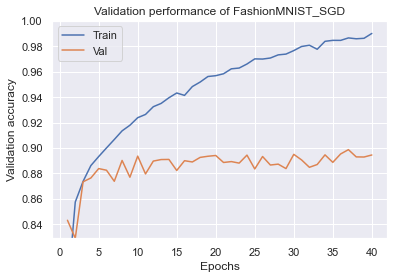

============= Test accuracy: 89.09% ==============



In [27]:
SGD_model = copy.deepcopy(base_model).to(device)
SGD_results = train_model(
    SGD_model, "FashionMNIST_SGD", lambda params: SGD(params, lr=1e-1), max_epochs=40, batch_size=256
)

Model file of "FashionMNIST_SGDMom" already exists. Skipping training...


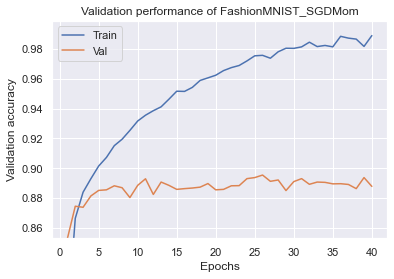

============= Test accuracy: 88.83% ==============



In [28]:
SGDMom_model = copy.deepcopy(base_model).to(device)
SGDMom_results = train_model(
    SGDMom_model,
    "FashionMNIST_SGDMom",
    lambda params: SGDMomentum(params, lr=1e-1, momentum=0.9),
    max_epochs=40,
    batch_size=256,
)

Model file of "FashionMNIST_Adam" already exists. Skipping training...


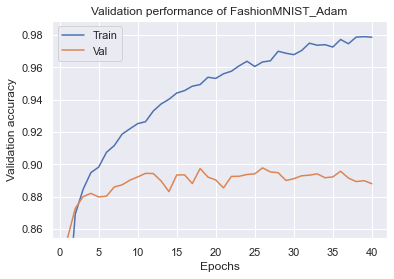

============= Test accuracy: 89.46% ==============



In [29]:
Adam_model = copy.deepcopy(base_model).to(device)
Adam_results = train_model(
    Adam_model, "FashionMNIST_Adam", lambda params: Adam(params, lr=1e-3), max_epochs=40, batch_size=256
)

In [30]:
def pathological_curve_loss(w1, w2):
    # Example of a pathological curvature. There are many more possible, feel free to experiment here!
    x1_loss = torch.tanh(w1) ** 2 + 0.01 * torch.abs(w1)
    x2_loss = torch.sigmoid(w2)
    return x1_loss + x2_loss

C:\Users\spruce\AppData\Local\Temp/ipykernel_26524/1102210584.py:5: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d") if plot_3d else fig.gca()


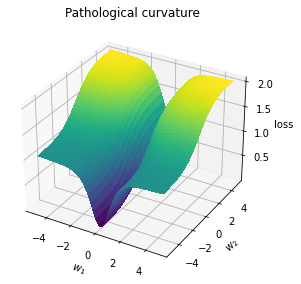

In [31]:
def plot_curve(
    curve_fn, x_range=(-5, 5), y_range=(-5, 5), plot_3d=False, cmap=cm.viridis, title="Pathological curvature"
):
    fig = plt.figure()
    ax = fig.gca(projection="3d") if plot_3d else fig.gca()

    x = torch.arange(x_range[0], x_range[1], (x_range[1] - x_range[0]) / 100.0)
    y = torch.arange(y_range[0], y_range[1], (y_range[1] - y_range[0]) / 100.0)
    x, y = torch.meshgrid([x, y])
    z = curve_fn(x, y)
    x, y, z = x.numpy(), y.numpy(), z.numpy()

    if plot_3d:
        ax.plot_surface(x, y, z, cmap=cmap, linewidth=1, color="#000", antialiased=False)
        ax.set_zlabel("loss")
    else:
        ax.imshow(z.T[::-1], cmap=cmap, extent=(x_range[0], x_range[1], y_range[0], y_range[1]))
    plt.title(title)
    ax.set_xlabel(r"$w_1$")
    ax.set_ylabel(r"$w_2$")
    plt.tight_layout()
    return ax


sns.reset_orig()
_ = plot_curve(pathological_curve_loss, plot_3d=True)
plt.show()

In [33]:
def train_curve(optimizer_func, curve_func=pathological_curve_loss, num_updates=100, init=[5, 5]):
    """
    Args:
        optimizer_func: Constructor of the optimizer to use. Should only take a parameter list
        curve_func: Loss function (e.g. pathological curvature)
        num_updates: Number of updates/steps to take when optimizing
        init: Initial values of parameters. Must be a list/tuple with two elements representing w_1 and w_2
    Returns:
        Numpy array of shape [num_updates, 3] with [t,:2] being the parameter values at step t, and [t,2] the loss at t.
    """
    weights = nn.Parameter(torch.FloatTensor(init), requires_grad=True)
    optim = optimizer_func([weights])

    list_points = []
    for _ in range(num_updates):
        loss = curve_func(weights[0], weights[1])
        list_points.append(torch.cat([weights.data.detach(), loss.unsqueeze(dim=0).detach()], dim=0))
        optim.zero_grad()
        loss.backward()
        optim.step()
    points = torch.stack(list_points, dim=0).numpy()
    return points

In [34]:
SGD_points = train_curve(lambda params: SGD(params, lr=10))
SGDMom_points = train_curve(lambda params: SGDMomentum(params, lr=10, momentum=0.9))
Adam_points = train_curve(lambda params: Adam(params, lr=1))

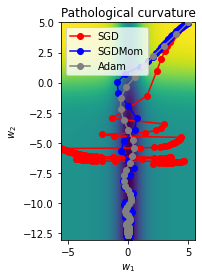

In [35]:
all_points = np.concatenate([SGD_points, SGDMom_points, Adam_points], axis=0)
ax = plot_curve(
    pathological_curve_loss,
    x_range=(-np.absolute(all_points[:, 0]).max(), np.absolute(all_points[:, 0]).max()),
    y_range=(all_points[:, 1].min(), all_points[:, 1].max()),
    plot_3d=False,
)
ax.plot(SGD_points[:, 0], SGD_points[:, 1], color="red", marker="o", zorder=1, label="SGD")
ax.plot(SGDMom_points[:, 0], SGDMom_points[:, 1], color="blue", marker="o", zorder=2, label="SGDMom")
ax.plot(Adam_points[:, 0], Adam_points[:, 1], color="grey", marker="o", zorder=3, label="Adam")
plt.legend()
plt.show()

C:\Users\spruce\AppData\Local\Temp/ipykernel_26524/1102210584.py:5: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d") if plot_3d else fig.gca()


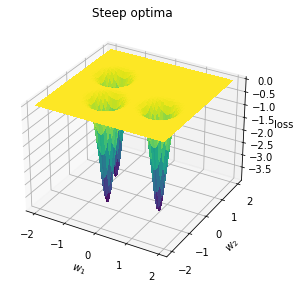

In [36]:
def bivar_gaussian(w1, w2, x_mean=0.0, y_mean=0.0, x_sig=1.0, y_sig=1.0):
    norm = 1 / (2 * np.pi * x_sig * y_sig)
    x_exp = (-1 * (w1 - x_mean) ** 2) / (2 * x_sig ** 2)
    y_exp = (-1 * (w2 - y_mean) ** 2) / (2 * y_sig ** 2)
    return norm * torch.exp(x_exp + y_exp)


def comb_func(w1, w2):
    z = -bivar_gaussian(w1, w2, x_mean=1.0, y_mean=-0.5, x_sig=0.2, y_sig=0.2)
    z -= bivar_gaussian(w1, w2, x_mean=-1.0, y_mean=0.5, x_sig=0.2, y_sig=0.2)
    z -= bivar_gaussian(w1, w2, x_mean=-0.5, y_mean=-0.8, x_sig=0.2, y_sig=0.2)
    return z


_ = plot_curve(comb_func, x_range=(-2, 2), y_range=(-2, 2), plot_3d=True, title="Steep optima")

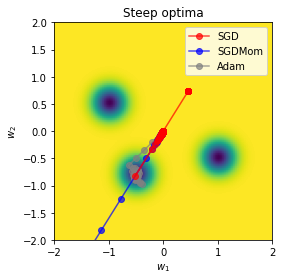

In [37]:
SGD_points = train_curve(lambda params: SGD(params, lr=0.5), comb_func, init=[0, 0])
SGDMom_points = train_curve(lambda params: SGDMomentum(params, lr=1, momentum=0.9), comb_func, init=[0, 0])
Adam_points = train_curve(lambda params: Adam(params, lr=0.2), comb_func, init=[0, 0])

all_points = np.concatenate([SGD_points, SGDMom_points, Adam_points], axis=0)
ax = plot_curve(comb_func, x_range=(-2, 2), y_range=(-2, 2), plot_3d=False, title="Steep optima")
ax.plot(SGD_points[:, 0], SGD_points[:, 1], color="red", marker="o", zorder=3, label="SGD", alpha=0.7)
ax.plot(SGDMom_points[:, 0], SGDMom_points[:, 1], color="blue", marker="o", zorder=2, label="SGDMom", alpha=0.7)
ax.plot(Adam_points[:, 0], Adam_points[:, 1], color="grey", marker="o", zorder=1, label="Adam", alpha=0.7)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
plt.legend()
plt.show()